In [1]:
from jax import numpy as jnp, random, jit
import jax
import thermox
from time import time
import matplotlib.pyplot as plt

2024-06-04 13:14:57.374262: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


We want to simulate an OU process
$$
dx = -A(x-b)dt + \mathcal{N}(0, Ddt)
$$
and compare `thermox` with and without an associative scan. This enables one to parallelize the time steps the solver takes, and have a complexity in $O(T/p + \log(T))$ for $p$ cores and $T$ timesteps.

In [2]:
# Define dimension
dim = 100

# Set float64 precision (with the parallel scan, float32 can lead to precision errors)
jax.config.update("jax_enable_x64", True)

In [3]:
# Master key
key = random.PRNGKey(0)

In [4]:
# Function to generate a random wishart matrix
def sample_wishart(key, dim, df):
    G = random.normal(key, (dim, df))
    return G @ G.T

In [5]:
# Generate A from Wishart distribution
key, A_key = random.split(key)
df_A = 10
A = sample_wishart(A_key, dim, df_A)

# Perturb to ensure it is positive definite
A += 1e-3 * jnp.eye(dim)


In [6]:
# Generate x0 and b from normal distribution
key, x0_key, b_key = random.split(key, 3)
x0 = random.normal(x0_key, (dim,))
b = random.normal(b_key, (dim,))

In [7]:
# Identity D
D = jnp.eye(dim)
D_sqrt = jnp.linalg.cholesky(D)

In [8]:
# Function to simulate from thermox
@jit
def simulate_thermox(rk, ts):
    return thermox.sample(rk, ts, x0, A, b, D, associative_scan=False)

@jit
def simulate_thermox_as(rk, ts):
    return thermox.sample(rk, ts, x0, A, b, D, associative_scan=True)

The following script runs `thermox.sample` with and without associative scan, for up to $\sim1.5$ million time steps (takes $\sim3$ minutes to run on an A100).

In [9]:
# Time the two simulators
# T_range = [10, 100, 1000, 10000]
T_range = jnp.logspace(3, 6.2, 6)

# Init run for compilation
simulate_thermox(key, jnp.arange(2.)).block_until_ready()
simulate_thermox_as(key, jnp.arange(2.)).block_until_ready()

thermox_times = []
thermox_as_times = []

for T in T_range:
    print(f"Running for T={T}")
    ts = jnp.arange(0, T, 1.)

    # Thermox
    start = time()
    vals_t = simulate_thermox(key, ts).block_until_ready()
    end = time()
    thermox_times.append(end - start)
    
    # Thermox Associative Scan
    start = time()
    vals_as = simulate_thermox_as(key, ts).block_until_ready()
    end = time()
    thermox_as_times.append(end - start)
    

Running for T=1000.0
Running for T=4365.158322401666
Running for T=19054.607179632483
Running for T=83176.37711026709
Running for T=363078.05477010173
Running for T=1584893.1924611141


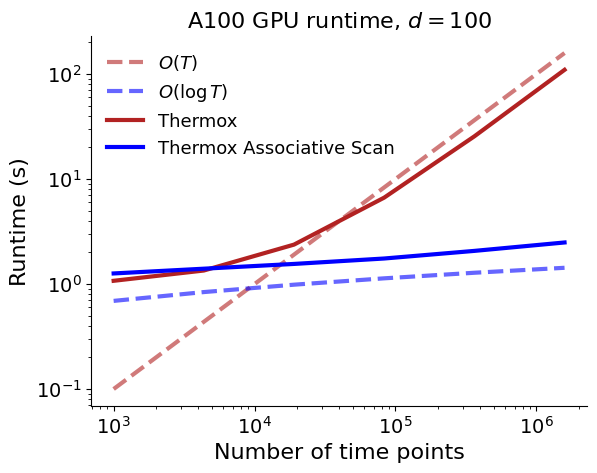

In [21]:
linewidth = 3
fontsize = 16
plt.title("A100 GPU runtime, $d=100$",fontsize=fontsize)

plt.plot(T_range, 1e-4*T_range, label=r"$O(T)$", color="firebrick", linestyle="--", linewidth=linewidth, alpha=0.6)
plt.plot(T_range, 1e-1*jnp.log(T_range), label=r"$O(\log T)$", color="blue", linestyle="--", linewidth=linewidth, alpha=0.6)
plt.plot(T_range, thermox_times, label="Thermox", color="firebrick", linewidth=linewidth)
plt.plot(T_range, thermox_as_times, label="Thermox Associative Scan", color="blue", linewidth=linewidth)

plt.xlabel("Number of time points", fontsize=fontsize)
plt.ylabel("Runtime (s)", fontsize=fontsize)

legend_fontsize = 13
plt.legend(frameon=False, fontsize=legend_fontsize)
plt.xscale("log")
plt.yscale("log")

ticks_fontsize = 14
plt.xticks(fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

And there you have it! The runtime depends on $\log(T)$ when we use the associative scan as expected. For a small number of time points, the associative scan runtime can be a bit slower due to parallelization overhead, but it becomes quickly advantageous.